# Yet Another an End-to-End Time Series Project Tutorial

George Vinogradov. [Reference](https://towardsdatascience.com/yet-another-an-end-to-end-time-series-project-tutorial-37390bcea38e). [Code](https://github.com/VinGeorge/Time-series-projects/blob/master/Time-Series-Prediction-Tutorial.ipynb). [Data](https://archive.ics.uci.edu/ml/datasets/Air+Quality)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

%matplotlib inline

csvfile = '.\\data\\pharmasales\\salesdaily.csv'

df = pd.read_csv(csvfile)
#df = pd.read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True) 
print(df.shape)
df.head(5)

(2106, 13)


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
datum           2106 non-null object
M01AB           2106 non-null float64
M01AE           2106 non-null float64
N02BA           2106 non-null float64
N02BE           2106 non-null float64
N05B            2106 non-null float64
N05C            2106 non-null float64
R03             2106 non-null float64
R06             2106 non-null float64
Year            2106 non-null int64
Month           2106 non-null int64
Hour            2106 non-null int64
Weekday Name    2106 non-null object
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [3]:
df.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000
mean,5.033683,3.895830,3.880441,29.917095,8.853627,0.593522,5.512262,2.900198,2016.401235,6.344255,275.945869
std,2.737579,2.133337,2.384010,15.590966,5.605605,1.092988,6.428736,2.415816,1.665060,3.386954,1.970547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000,190.000000
25%,3.000000,2.340000,2.000000,19.000000,5.000000,0.000000,1.000000,1.000000,2015.000000,3.000000,276.000000
50%,4.990000,3.670000,3.500000,26.900000,8.000000,0.000000,4.000000,2.000000,2016.000000,6.000000,276.000000
75%,6.670000,5.138000,5.200000,38.300000,12.000000,1.000000,8.000000,4.000000,2018.000000,9.000000,276.000000
max,17.340000,14.463000,16.000000,161.000000,54.833333,9.000000,45.000000,15.000000,2019.000000,12.000000,276.000000


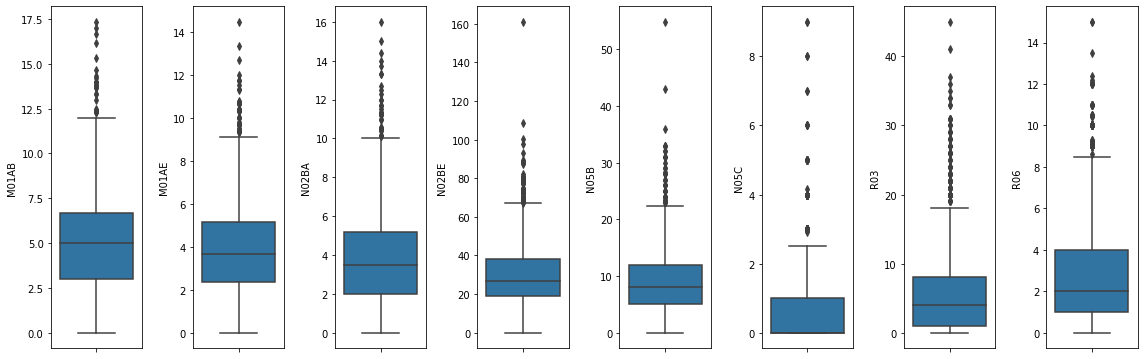

In [4]:
columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
number_of_columns = len(columns)

plt.figure(figsize=(2*number_of_columns,10))
for category in range(0,number_of_columns):
    plt.subplot(2 , number_of_columns , category+1)
    sns.boxplot(df[columns[category]], orient='v')
    plt.tight_layout()

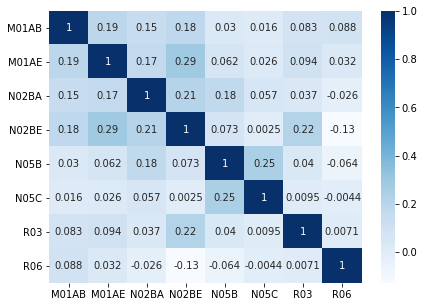

In [5]:
# demonstration of the correlation matrix for categories above
corr = df[columns].corr()
plt.figure(figsize = (7,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, cmap='Blues');

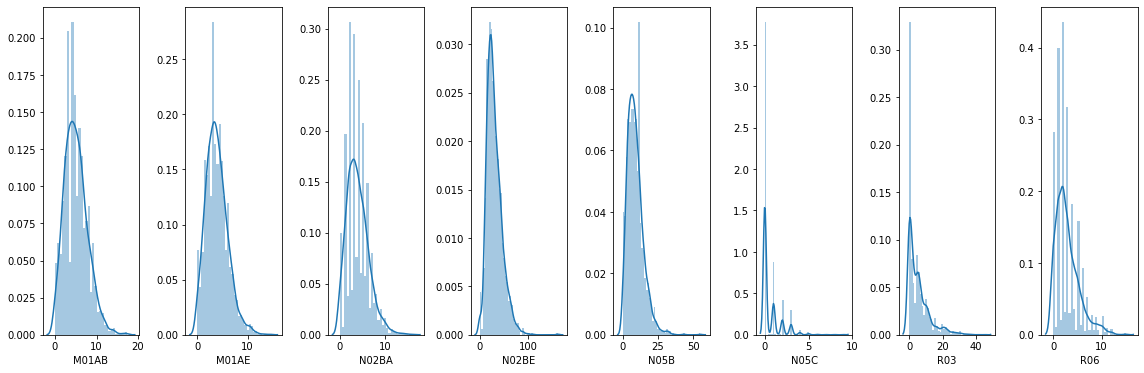

In [6]:
plt.figure(figsize=(2*number_of_columns,10))
for category in range(0,number_of_columns):
    plt.subplot(2 ,number_of_columns , category+1)
    sns.distplot(df[columns[category]], kde=True)
    plt.tight_layout()

In [7]:
#ATC codes by types of category
atc_codes = {'Antirheumatic' : ['M01AB','M01AE'],
             'Analgesics' : ['N02BA','N02BE'],
             'Psycholeptics' : ['N05C','N05B'],
             'Airway diseases': ['R03'],
             'Antihistamines': ['R06']}

In [8]:
#create a function which will help us to explore a sales dynamic
def create_charts(data, markets, title, index, freq, DF=None):
    'Creates line chart with time defined frequency by markets'
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    for codes in markets:
        ax.set_title('{} Market'.format(title))
        index = data[codes].resample(freq).sum().index
        plt.plot(index, data[codes].resample(freq).sum())
        register_matplotlib_converters()
        plt.legend();

In [9]:
#convert a column with dates to pandas daytime format
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index('datum')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


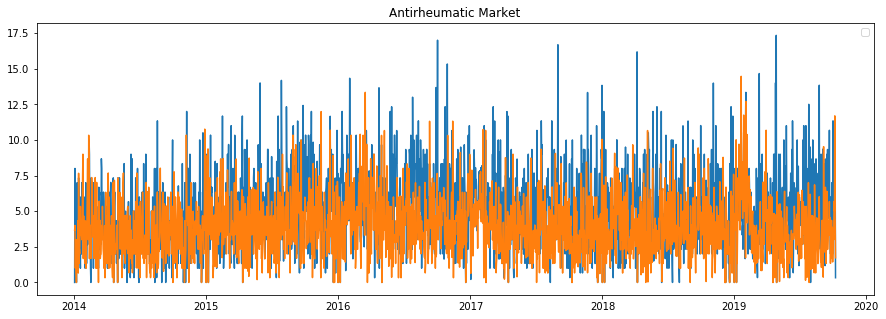

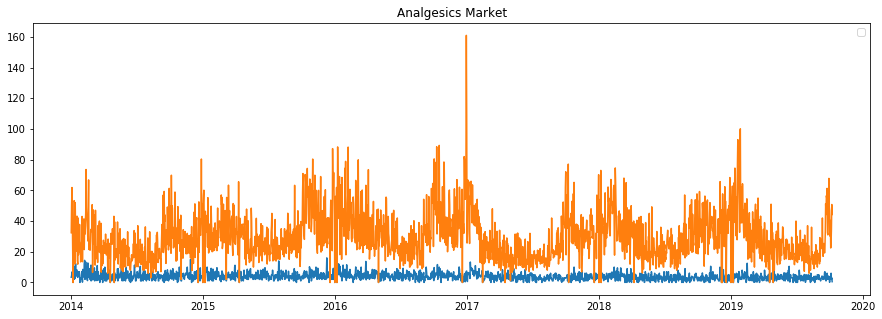

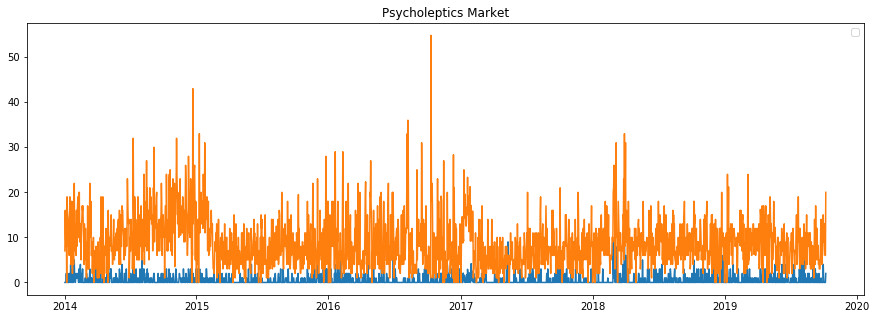

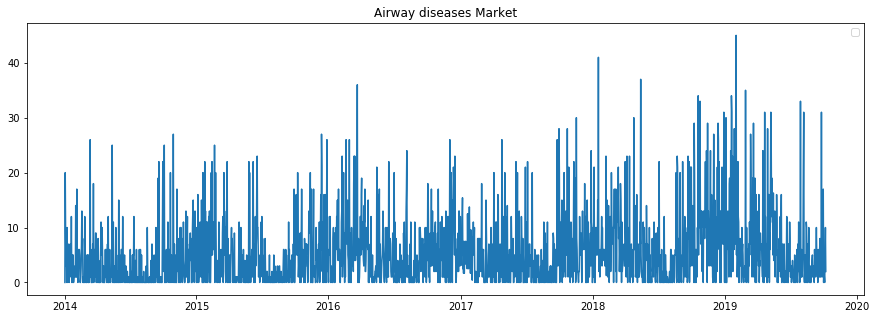

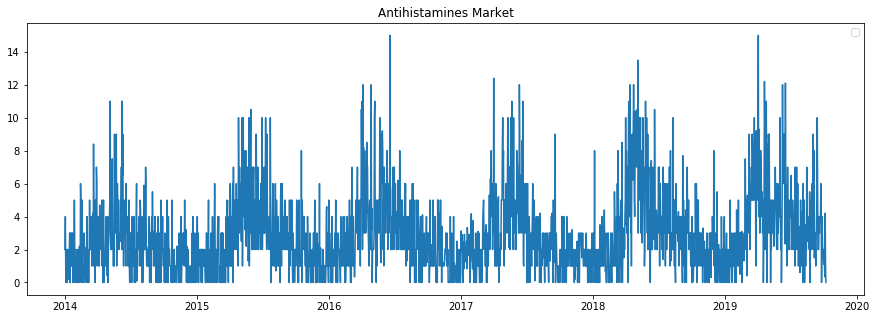

In [10]:
#use predefined the function above to explore sales dynamic
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.index, 'D', DF=True) # D, W, M, Q, Y

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


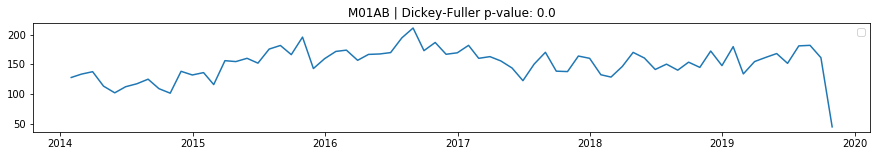

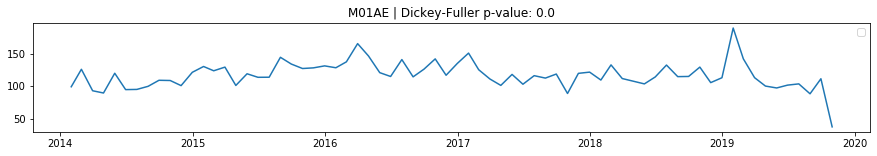

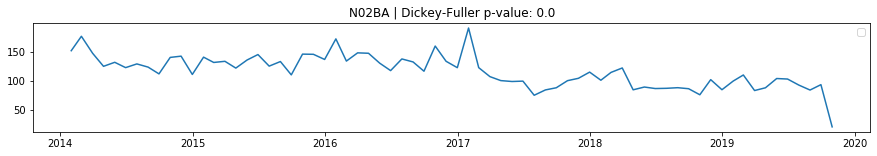

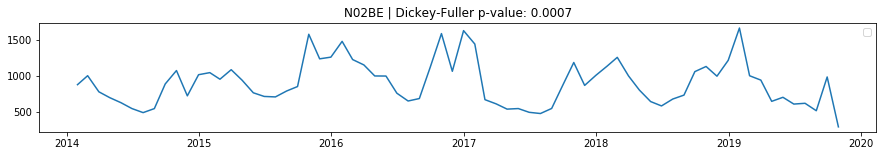

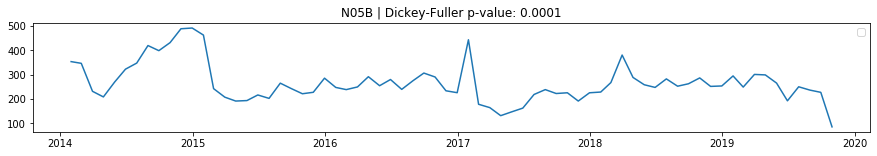

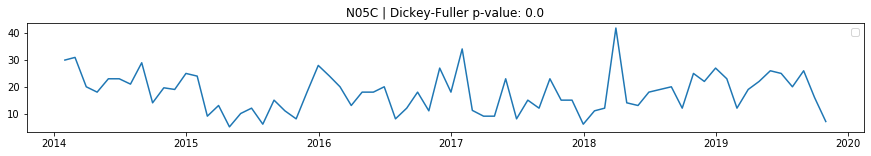

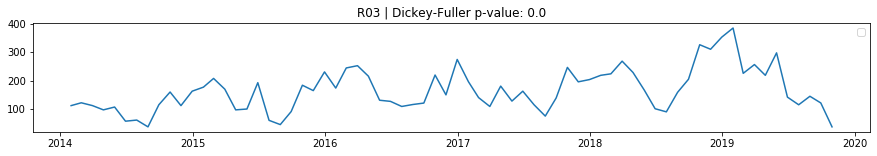

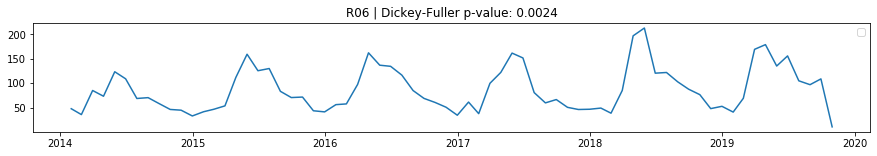

In [11]:
for code in columns:
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,2))
    ax.set_title('{} | Dickey-Fuller p-value: {}'.format(code , round(adfuller(df[code])[1], 4)))
    index = df[code].resample('M').sum().index
    plt.plot(index, df[code].resample('M').sum())
    register_matplotlib_converters()
    plt.legend();

In [12]:
def DF_test(data):
    'Prints the Dickey-Fuller test'
    statistics = adfuller(data)
    print('DF Statistic: {}'.format(round(statistics[0], 2)))
    print('p-value: {}'.format(round(statistics[1], 4)))
    print('Critical Values:')
    for key, value in statistics[4].items():
        print('\t{}: {}'.format(key, round(value, 2)))

In [13]:
DF_test(df['R03'])

DF Statistic: -5.13
p-value: 0.0
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


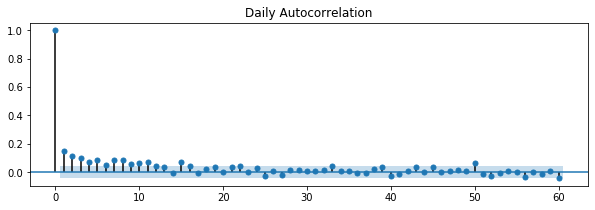

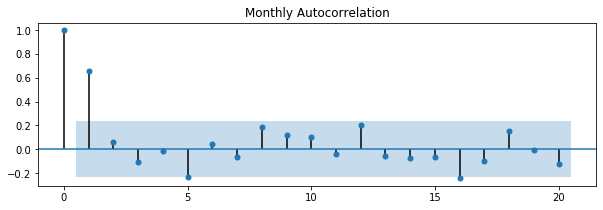

In [14]:
#look at autocorrelation
fig, ax1 = plt.subplots(figsize=(10, 3))
fig, ax2 = plt.subplots(figsize=(10, 3))
daily_autocorr = plot_pacf(df['R03'], lags=60, title='Daily Autocorrelation', ax=ax1)
monthly_autocorr = plot_pacf(df['R03'].resample('M').sum(), lags=20, title='Monthly Autocorrelation', ax=ax2)

To demonstrate how works the .plot_pacf function we took data with seasonality.

If autocorrelation values are close to 0, it is mean that values between lagged observations are not correlated with one another. At the same time, partial autocorrelations with values close to 1 or -1 demonstrate that there exist strong positive or negative correlations between the lagged observations of the time series.

The blue shaded regions indicate borders of the confidence intervals. If partial autocorrelation values are beyond this confidence interval regions, then you can assume that the observed partial autocorrelation values are statistically significant.

In [15]:
#let's dedicate the Analgesics market for the further steps
data = df[atc_codes['Analgesics']].copy()
data = data.set_index(df.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 2 columns):
N02BA    2106 non-null float64
N02BE    2106 non-null float64
dtypes: float64(2)
memory usage: 49.4 KB


In [16]:
#combine ATC codes related to the same market in one
data['volume_sales'] = data['N02BA'] + data['N02BE']
data = data.drop(columns=['N02BA', 'N02BE'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 1 columns):
volume_sales    2106 non-null float64
dtypes: float64(1)
memory usage: 32.9 KB


In [17]:
#split data for 2 independent groups. The first one we will use to training models and second one as test
train_data = data['01/01/2017': '04/30/2019'].copy()
test_data = data['05/1/2019':].copy()

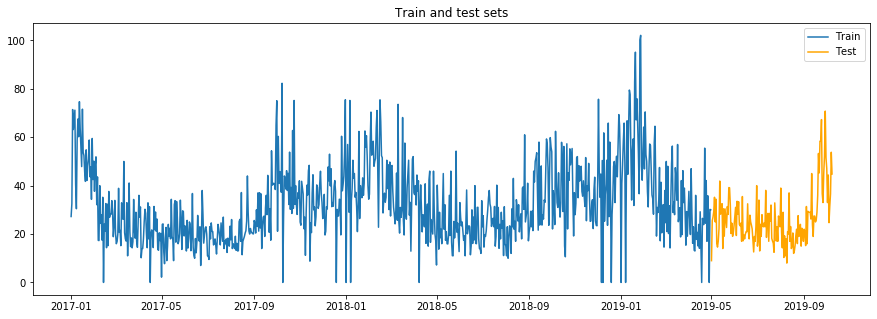

In [18]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['volume_sales'], label='Train')
plt.plot(test_data.index, test_data['volume_sales'], color='orange', label='Test')
plt.legend()
plt.title('Train and test sets')
register_matplotlib_converters()
plt.show()

## Initial preprocessing and feature generation

In [64]:
# transform training data & save lambda value
train, fitted_lambda = stats.boxcox(train_data.volume_sales+1) #add 1 to handle zero values
df_train = pd.DataFrame(train, index=train_data.index, columns=['volume_sales'])

# use lambda value to transform test data
test = stats.boxcox(test_data.volume_sales, fitted_lambda)
df_test = pd.DataFrame(test, index=test_data.index, columns=['volume_sales'])

Text(0.5, 0.98, 'Transformed data')

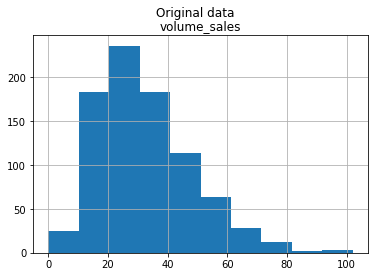

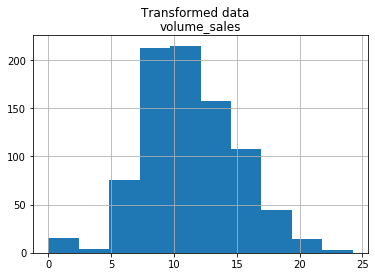

In [72]:
train_data.hist()
plt.suptitle("Original data");
df_train.hist()
plt.suptitle("Transformed data")

Text(0.5, 0.98, 'Transformed data')

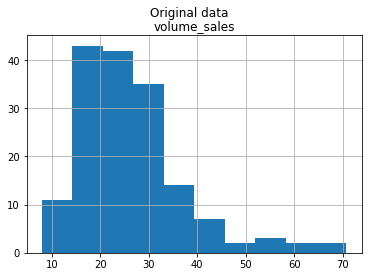

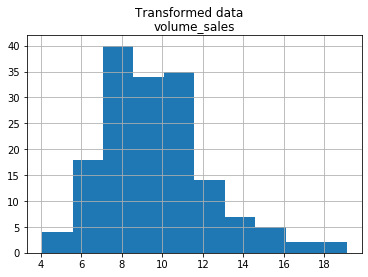

In [73]:
test_data.hist()
plt.suptitle("Original data");
df_test.hist()
plt.suptitle("Transformed data")

In [75]:
def linreg(X):
    n = X.shape[0]
    x = np.concatenate((np.ones(n), np.arange(n)),).reshape(2, n).T
    y = X.reshape(-1,1)
    theta = np.linalg.pinv(x.dot(x.T)).dot(x).T.dot(y)

    return np.array([[1, n]]).dot(theta)

In [76]:
def create_features(data, lags_list):
    'create predictors for the model'
    X = pd.DataFrame(data.values.ravel(), index=data.index, columns=['y'])
    for window in lags_list:
        X['lin_reg_{}'.format(window)] = X['y'].shift(1).rolling(window=window).apply(linreg, raw=True)
        X['shift_{}'.format(window)] = X['y'].shift(window)
        X['diff_{}'.format(window)] = X['y'].shift(1).diff(window)
        X['rolling_mean_{}'.format(window)] = X['y'].shift(1).rolling(window=window).mean()
        X['rolling_max_{}'.format(window)] = X['y'].shift(1).rolling(window=window).max()
        X['rolling_std_{}'.format(window)] = X['y'].shift(1).rolling(window=window).std()
        X['rolling_min_{}'.format(window)] = X['y'].shift(1).rolling(window=window).min()
        
    X = X.fillna(np.nanmedian(X))
    
    return X.drop('y', axis=1)

In [78]:
def create_dummies(data):
    'return dataset with dummy variables of the day'
    X = pd.DataFrame({'day_of_week' : data.index.weekday_name}, data.index)
    days = pd.get_dummies(X['day_of_week'])
    result = pd.concat([data, days], axis=1, sort=False)
    
    return result

In [79]:
def scaler(data):
    'apply the sklearn MinMaxScaler'
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    result = pd.DataFrame(scaled, columns=[data.columns], index=data.index)
    
    return result

In [80]:
lags = [2, 7, 14]
X_train = scaler(create_dummies(create_features(df_train, lags)))
X_train

,lin_reg_2,shift_2,diff_2,rolling_mean_2,rolling_max_2,rolling_std_2,rolling_min_2,lin_reg_7,shift_7,diff_7,...,rolling_max_14,rolling_std_14,rolling_min_14,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
datum,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.536214,0.377049,0.744849,0.275572,0.188671,0.610134,0.381487,0.331132,0.377049,0.759088,...,0.000000,1.000000,0.664092,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-02,0.536214,0.377049,0.744849,0.275572,0.188671,0.610134,0.381487,0.331132,0.377049,0.759088,...,0.000000,1.000000,0.664092,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.605136,0.429785,0.744849,0.369189,0.327722,0.061823,0.434843,0.331132,0.377049,0.759088,...,0.000000,1.000000,0.664092,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-04,0.852623,0.483815,0.740061,0.586201,0.738904,0.361247,0.489510,0.331132,0.377049,0.759088,...,0.000000,1.000000,0.664092,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-05,0.666135,0.799527,0.665533,0.736471,0.738904,0.068293,0.748551,0.331132,0.377049,0.759088,...,0.000000,1.000000,0.664092,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26,0.398713,0.570829,0.440612,0.352034,0.441050,0.294395,0.317233,0.410464,0.422069,0.719080,...,0.488511,0.333525,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-27,0.681221,0.313542,0.460785,0.318943,0.367620,0.229883,0.317233,0.430731,0.394160,0.579749,...,0.488511,0.346631,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-04-28,0.531934,0.514449,0.581110,0.393608,0.367620,0.084322,0.445944,0.385667,0.395255,0.550905,...,0.488511,0.341055,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Train

In [81]:
#define models and their initial state
model_ridge = Ridge()
model_lasso = Lasso()
model_tree = DecisionTreeRegressor()
model_forest = RandomForestRegressor()
models = {'forest': model_forest,
          'lasso': model_lasso,
          'ridge': model_ridge,
          'tree': model_tree}

In [82]:
def train(X, actual, model, n_splits=10):
    'trains models and apply cross-validation for the time series data'
    cv = TimeSeriesSplit(n_splits=n_splits)
    y = []
    i = 0 

    for train, test in cv.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = actual[train], actual[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if i == 0:
            y.extend(model.predict(X_train))
        i+=1
        y.extend(y_pred)
        
    return y

In [83]:
df = pd.DataFrame()
for model in models.items():
    df[model[0]] = train(X_train, df_train.values.ravel(), model[1])

In [88]:
def model_to_chart(y, y_pred, model_name, index):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    ax.set_title('Model:{}, MAE = {:.3f}'.format(model_name, mean_absolute_error(y, y_pred)))
    plt.plot(index, y, label='True')
    plt.plot(index, y_pred, label='Predicted')
    plt.plot(index, y - y_pred, label='error', alpha=.3)
    plt.legend()
    register_matplotlib_converters();

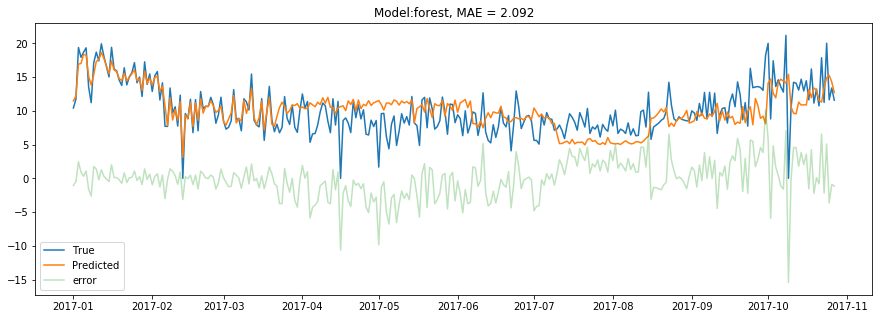

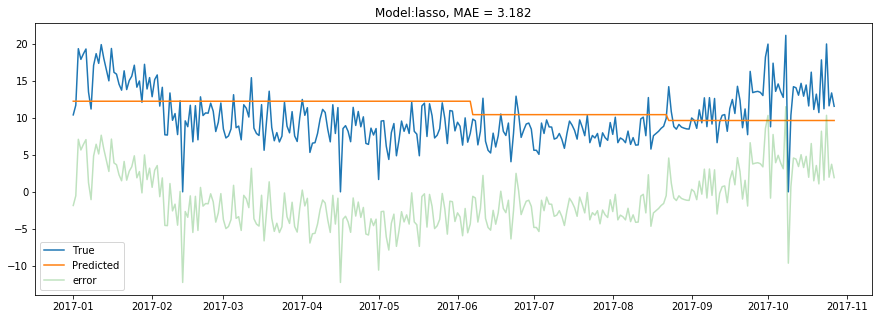

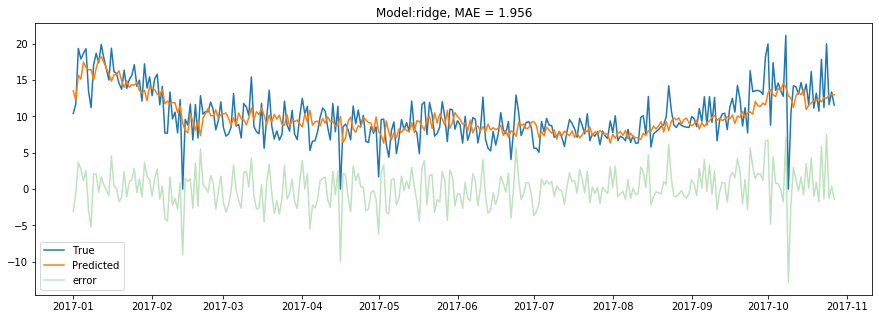

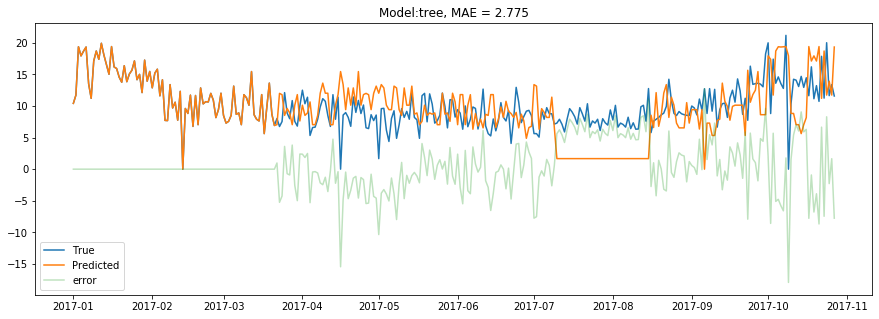

In [89]:
for model in models.items():
    model_to_chart(y=df_train[:300].values.ravel(), 
                y_pred= df[:300][model[0]].values, 
                index = df_train[:300].index, 
                model_name=model[0])

## Test

In [90]:
def create_dates(data, n_steps_prediction):
    'creates 1 time step from the latest date'
    start_date = data.index[-1] + pd.DateOffset(1) #defines the latest date
    new_date = pd.date_range(start_date, periods=n_steps_prediction) #create dataset with dates
    
    return data.append(pd.DataFrame(index=new_date), sort=True) #add new values to the dateset

In [92]:
def forecaster(models, data, n_steps, lags_list):
    'predicts new values on the base of already predicted'

    df = create_dates(data, n_steps) #this line creates new dates
    
    for model in models.items(): #iterate over the models
        df[model[0]] = df.values[:,0] #provide original values to generate initial features
        for i in range(0, n_steps-1):
            #here we generate predictors and scale them
            x_features = scaler(create_dummies(create_features(df[model[0]], lags_list=lags_list))) 
            
            #predict new value
            y_pred = np.round(model[1].predict(x_features.iloc[-n_steps+i:-n_steps+i+1]), 2) 
            
            #this line adds predicted value into the end of dataset for the specific model
            df[model[0]].iloc[-n_steps+i] = y_pred 
        
    return df

Pay your attention, we are going to make predictions 30 time steps ahead. Also, important to remember that the features generation function uses historical data. For this reason, we have to give the 14 time steps from the train data to generate initial features

In [99]:
predicted_values = forecaster(models = models, data=df_train[-14:], n_steps=30, lags_list=lags)
predicted_values.head(5)

,volume_sales,forest,lasso,ridge,tree
2019-04-17,6.897372,6.897372,6.897372,6.897372,6.897372
2019-04-18,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-19,10.229646,10.229646,10.229646,10.229646,10.229646
2019-04-20,9.553232,9.553232,9.553232,9.553232,9.553232
2019-04-21,9.579772,9.579772,9.579772,9.579772,9.579772


In [100]:
predicted_values.drop(axis=1, columns='volume_sales', inplace=True)
predicted_values.head(5)

,forest,lasso,ridge,tree
2019-04-17,6.897372,6.897372,6.897372,6.897372
2019-04-18,0.000000,0.000000,0.000000,0.000000
2019-04-19,10.229646,10.229646,10.229646,10.229646
2019-04-20,9.553232,9.553232,9.553232,9.553232
2019-04-21,9.579772,9.579772,9.579772,9.579772


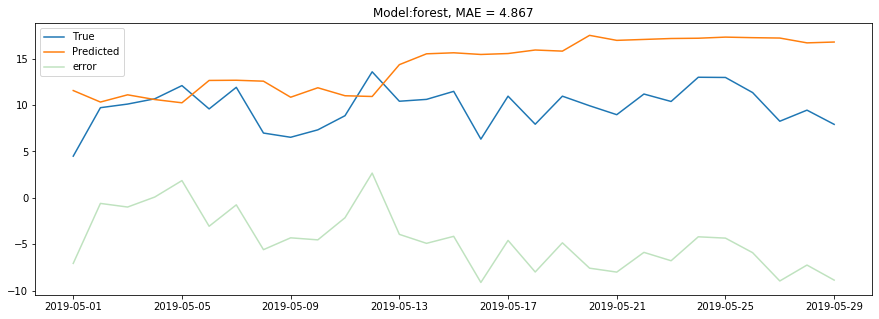

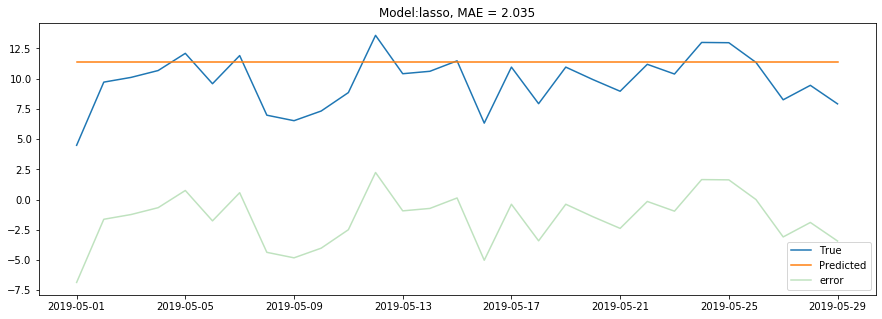

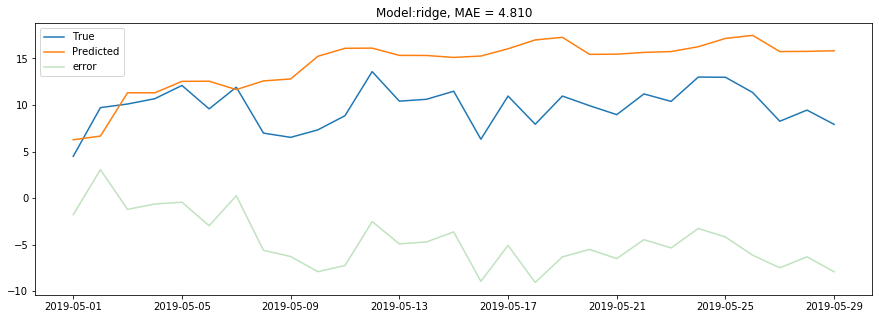

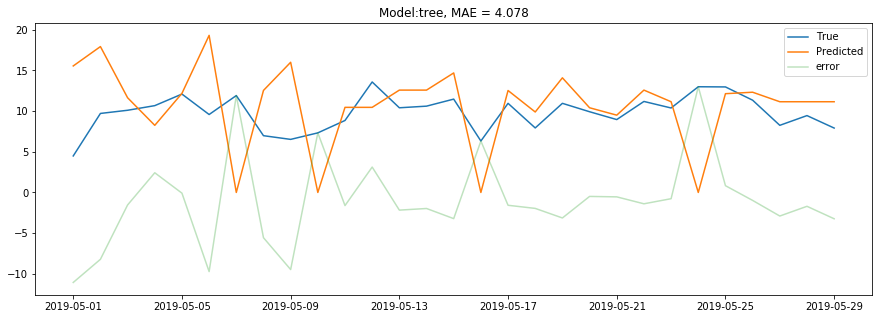

In [101]:
for model in models.items():
    model_to_chart(y=df_test.loc['2019-05-01':'2019-05-29'].values.ravel(), 
                y_pred= predicted_values.iloc[-30:-1][model[0]].values, 
                index = predicted_values.iloc[-30:-1].index, 
                model_name=model[0])

In [ ]:
## Do you remember that we have used the Box-Cox transformation?
### It is time to reverse!

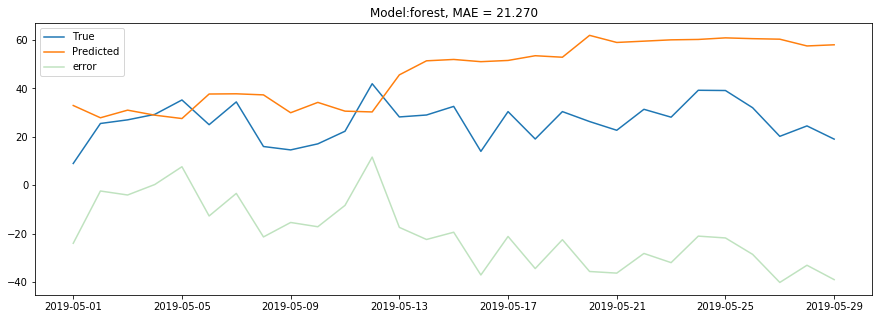

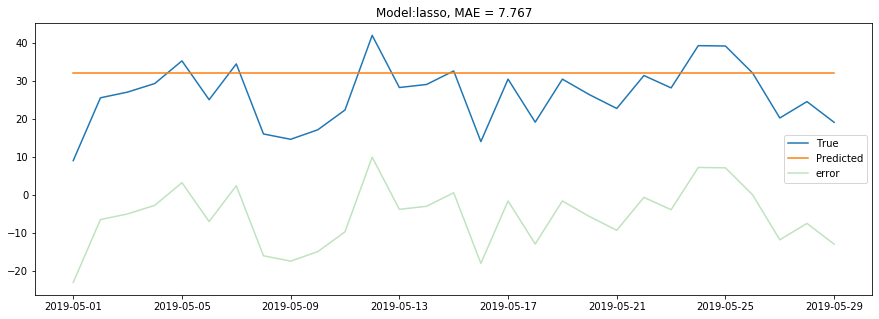

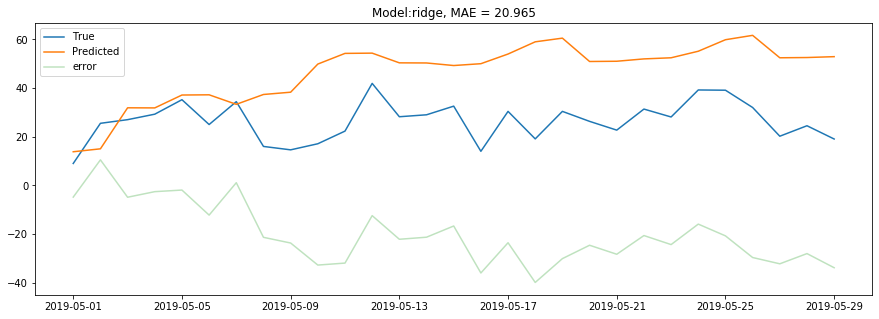

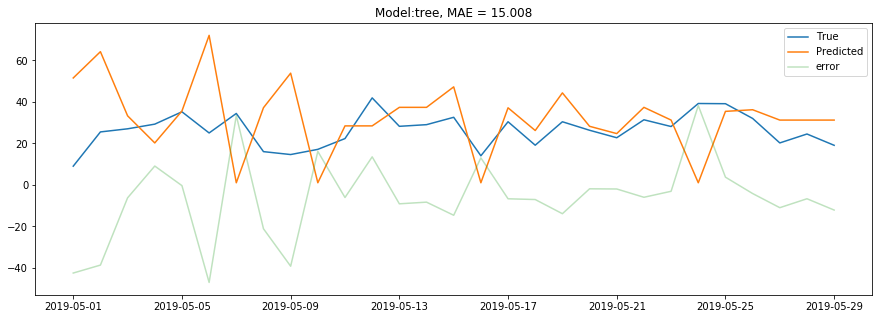

In [102]:
df_test = inv_boxcox(df_test, fitted_lambda)
predicted_values = inv_boxcox(predicted_values, fitted_lambda)

for model in models.items():
    model_to_chart(y=df_test.loc['2019-05-01':'2019-05-29'].values.ravel(), 
                y_pred= predicted_values.iloc[-30:-1][model[0]].values, 
                index = predicted_values.iloc[-30:-1].index, 
                model_name=model[0])